$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Neural Networks

Lucas Wilson

# Overview

You will write and apply code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below.  You will do this once for a regression problem and once for a classification problem. 

# Required Code

In [107]:
import neuralnetworks as nn
import mlutils as ml

from copy import deepcopy, copy
import time
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

Documentation is in the code itself

In [2]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify, verbose=False):
    """
    Args:
        * `X` is a matrix of input data of shape `nSamples x nFeatures`
        * `T` is a matrix of target data of shape `nSamples x nOutputs`
        * `trainFraction` is fraction of samples to use as training data. 1-`trainFraction` is number of samples for testing data
        * `hiddenLayerStructures` is list of network architectures. For example, to test two networks, one with one hidden layer of 20 units, and one with 3 hidden layers with 5, 10, and 20 units in each layer, this argument would be `[[20], [5, 10, 20]]`.
        * `numberRepetitions` is number of times to train a neural network. Calculate training and testing average performance (two separate averages) of this many training runs.
        * `numberIterations` is the number of iterations to run the scaled conjugate gradient algorithm when a neural network is trained.
        * `classify` is set to `True` if you are doing a classification problem, in which case `T` must be a single column of target class integers.

    Returns:
        `results` which is list with one element for each network structure tested. Each element is a list containing:
            * the hidden layer structure (as a list),
            * a list of training data performance for each repetition, 
            * a list of testing data performance for each repetition, and
            * the number of seconds it took to run this many repetitions for this network structure.
    """
    # Use mlutils to split the training and testing. The model's performance on testing is the most
    # important measurement since we care about the global scope of the problem and not just its
    # performance on a sample.
    trainX,trainT,testX,testT = ml.partition(X,T,(trainFraction,1-trainFraction),classification=classify)
    
    # Naturally, we return each result as a list. We start with it empty.
    results = []
    
    # We iterate over every hidden layer structure that we want to test
    for hiddenLayerStructure in hiddenLayerStructures:
        
        # We create the element of the results list:
        # list (network structure, training performance, testing performance, time to train)
        # network structure - the structure
        # training performance for each trial - a sampling of the actual performance distribution
        # testing performance for each trial - a sampling of the actual performance distribution
        # time to train - the total time it took to train the model
        resultsAppendage = [hiddenLayerStructure, [], [], 0]
        if verbose: print("Measuring:", hiddenLayerStructure)
        
        # we want to run multiple trials to get a good sense of how well the structure performs
        for _ in range(numberRepetitions):
            
            # initialize the network
            if classify:
                nnet = nn.NeuralNetworkClassifier(X.shape[1], hiddenLayerStructure, len(np.unique(T)))
            else:
                nnet = nn.NeuralNetwork(X.shape[1], hiddenLayerStructure, T.shape[1])
            
            # train on training data. Note that the model never sees testing data (this is what
            # makes the training data performance so valuable)
            startTime = time.time() # start the timer
            nnet.train(trainX, trainT, numberIterations)
            resultsAppendage[3] += time.time() - startTime # stop the timer
            
            # Use the trained model to predict outcomes on both training and testing data. The
            # model is allowed to see the test data now since it's no longer learning.
            trainY = nnet.use(trainX)
            testY = nnet.use(testX)
            
            # performance measurements are handled differently for classification vs regression
            if classify:
                trainPerformance = frac(trainT, trainY) # wrong / total
                testPerformance = frac(testT, testY)
            else:
                trainPerformance = msqe(trainT, trainY) # see below
                testPerformance = msqe(testT, testY)
                
            # Append the performance measurements
            resultsAppendage[1].append(trainPerformance)
            resultsAppendage[2].append(testPerformance)
        
        # record the results for the structure
        results.append(resultsAppendage)
    
        if verbose: print("Training time:", results[-1][3])
    # and of course return them to whoever asked
    return results

def msqe(T, Y):
    return np.sqrt(np.mean((T-Y)**2))

def frac(T, Y):
    # calculate the fraction of samples incorrectly classified for training and testing sets
    right = 0
    wrong = 0
    for t, y in zip(T, Y):
        if t==y:
            right+=1
        else:
            wrong+=1
    return wrong / (right + wrong)

I define MSQE as follows:
Let $E = T - Y$ where $T$ is actual values, $Y$ is predicted by the model, and $E,T,Y \epsilon \mathbb{R}^{n\times m}$

$MSQE = \sqrt{\frac{||E||_2^2}{nm}}$ where $||•||_2$ is $L_2$ matrix norm, $n$ is the number of samples, and $m$ is the number of features for the output of the model.

In [3]:
def summarize(results):
    """
    Args:
        The output of trainNNs()

    Returns:
        a list of lists like `results` but with the list of training performances
        replaced by their mean and the list of testing performances replaced by
        their mean.
    """
    results = deepcopy(results)
    for i,result in enumerate(results):
        results[i] = result[0], np.mean(result[1]), np.mean(result[2]), result[3]
    return results

In [4]:
def bestNetwork(summary):
    """
    Args:
        The output of summarize
        
    Returns:
        Returns the best element of `results`, determined by the element that has
        the smallest test performance.
    """
    best = 0
    bestValue = np.inf
    for i, result in enumerate(summary):
        value = result[2]
        if value < bestValue:
            best = i
            bestValue = value
    return summary[best]

These links helped me write the following:
* https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
* https://matplotlib.org/users/legend_guide.html

In [5]:
def plotSummary(summary):
    summary = sorted(deepcopy(summary), key=lambda x:x[2])
    length = 1
    x = np.arange(len(summary))*length
    width=.4*length
    plt.xticks(x, [str(e[0]) for e in summary])
    plt.bar(x, [e[1] for e in summary], width, color='b', label="training")
    plt.bar(x+width, [e[2] for e in summary], width, color='g', label="testing")
    plt.legend()

# Examples

In [6]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

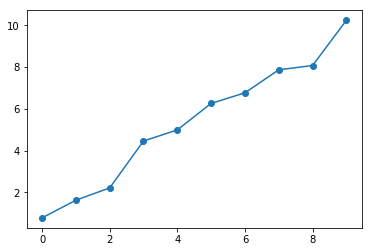

In [7]:
plt.plot(X, T, 'o-');

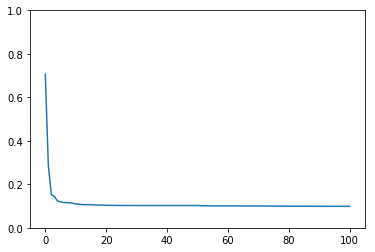

In [8]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

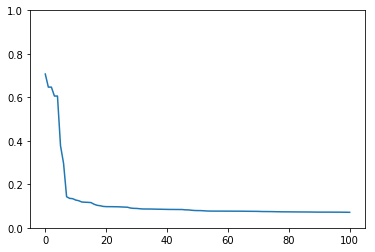

In [9]:
nnet = nn.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

## Remark:

As you can see, it trains pretty quickly and accurately. Dr. Anderson mentioned in class how small weights make non-linear activation functions act linear. Since the original function is linear, the quick convergence makes sense.

In [10]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 5, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 100, classify=False)

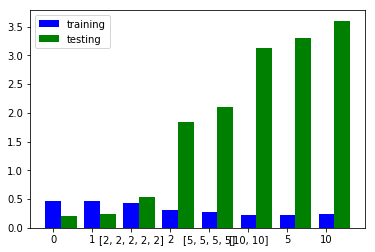

In [11]:
plotSummary(summarize(results))

In [12]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

(0, 0.4644482704666944, 0.20576189394061464, 0.0)
Hidden Layers 0 Average RMSE Training 0.46 Testing 0.21 Took 0.00 seconds


## Remark: Analysis

> Hummm...neural nets with no hidden layers did best on this simple data set.  Why?  Remember what "best" means.

The reason a neural network without hidden layers performs better than more complex ones is because..

1. A neural network without hidden layers is just linear and the actual function is linear, so naturally, the best model for a function is itself. That's why a no hidden layer neural network performs well.
2. Since there are no hidden layers, it can't over-fit to the training data since it's not complex enough. However, the more complex models which do over-fit fit to the noise added, so they fail to perform well on testing data since the learned noise is useless.

It's also interesting to note that as training performance increases, testing performance tends to decrease. This is because the model immediately begins to over-fit. I think that normally, both decrease, and at some point, testing begins to increase.

# Data for Regression Experiment

## Data Collection

In [29]:
!wget -nc -q http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv

In [30]:
def removeQuotes(word):
    return word[1:-1]
cols = tuple(range(1, 27))
colConverter = {}
for col in cols:
    colConverter[col] = removeQuotes
names = list(np.loadtxt('energydata_complete.csv', dtype=str, delimiter=",", usecols=cols, converters=colConverter)[0])
data = np.loadtxt('energydata_complete.csv', delimiter=",", skiprows=1, usecols=cols, converters=colConverter)

In [31]:
names[1:5] # only print some cuz space

['lights', 'T1', 'RH_1', 'T2']

In [32]:
data.shape

(19735, 26)

In [33]:
Xenergy, Xnames = data[:,2:], names[2:]
Tenergy, Tnames = data[:,:2], names[:2]

Xenergy.shape, Tenergy.shape

((19735, 24), (19735, 2))

In [34]:
Xnames[3:5], Tnames

(['RH_2', 'T3'], ['Appliances', 'lights'])

## Error analysis to determine number of iterations

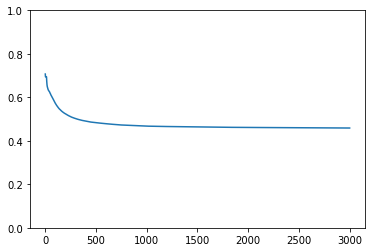

In [ ]:
trainFraction = 0.8
trainX,trainT,testX,testT = ml.partition(Xenergy,Tenergy,(trainFraction,1-trainFraction),classification=False)
nnet = nn.NeuralNetwork(Xenergy.shape[1], [20, 20], Tenergy.shape[1])
nnet.train(trainX, trainT, 3000)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

The error levels off around 500 but continues to decrease slightly.

## Structure performance analysis

In [ ]:
netsEnergy = [0, 5, 20, 50, [24, 12, 6],
              [10, 5], [20, 20], [30, 30], [40, 10]]
results = trainNNs(Xenergy, Tenergy, 0.8, netsEnergy, 3, 700, False, verbose=True)

Measuring: 0
Training time: 0.7031064033508301
Measuring: 5
Training time: 61.17958664894104
Measuring: 20
Training time: 147.93755054473877
Measuring: 50
Training time: 329.43933486938477
Measuring: [24, 12, 6]
Training time: 250.46534204483032
Measuring: [10, 5]
Training time: 112.4950897693634
Measuring: [20, 20]
Training time: 253.4375126361847
Measuring: [30, 30]
Training time: 368.0050370693207
Measuring: [40, 10]
Training time: 324.5706877708435


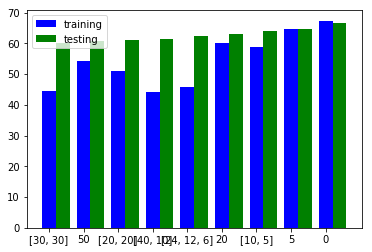

In [ ]:
plotSummary(summarize(results))

In [ ]:
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*bestNetwork(summarize(results))))

Hidden Layers [30, 30] Average RMSE Training 44.45 Testing 60.15 Took 368.01 seconds


Notice that large numbers of layers tends to over-fit the data. Due to its complexity, it's capable of memorizing some of the data, so when we test it on testing data, it performs poorly because it is using what it's stored not what it's generalized.

We can see that this is what it is doing when our training accuracy is much higher than our testing accuracy. As seen in the middle of the graph. Typically, we want to identify where testing accuracy stops lowering and starts rising. That threshold  is where the model begins to over-fit.

Now train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date).  As before use `ml.partition` to produce the training and testing sets.

For the testing data, plot the predicted and actual `Appliances` energy use, and the predicted and actual `lights` energy use, in two separate plots.  Discuss what you see.

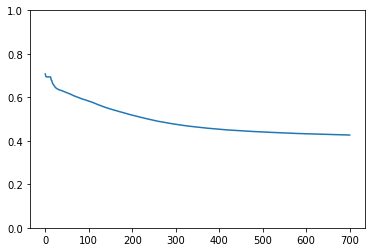

In [35]:
trainFraction = 0.8
trainX,trainT,testX,testT = ml.partition(Xenergy,Tenergy,(trainFraction,1-trainFraction),classification=False)
nnet = nn.NeuralNetwork(Xenergy.shape[1], [30, 30], Tenergy.shape[1])
nnet.train(trainX, trainT, 700)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

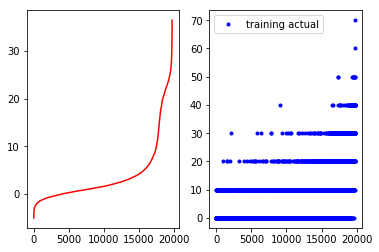

In [43]:
outY = list(nnet.use(trainX)[:,1]) +  list(nnet.use(testX)[:,1])
outT = list(trainT[:,1]) + list(testT[:,1])
zipped = sorted(list(zip(outY, outT)))
plt.subplot(121)
plt.plot([x[0] for x in zipped], 'r-', label="training predicted")
plt.subplot(122)
plt.plot([x[1] for x in zipped], 'b.', label="training actual")
plt.legend()

It's hard to tell, but since I sorted the prediction data, it's easy to see that the actual data doesn't correlate much with the curve on the left. The predictions like to be very small. 

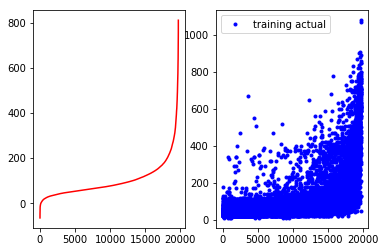

In [44]:
outY = list(nnet.use(trainX)[:,0]) +  list(nnet.use(testX)[:,0])
outT = list(trainT[:,0]) + list(testT[:,0])
zipped = sorted(list(zip(outY, outT)))
plt.subplot(121)
plt.plot([x[0] for x in zipped], 'r-', label="training predicted")
plt.subplot(122)
plt.plot([x[1] for x in zipped], 'b.', label="training actual")
plt.legend()

The lights graph shoes something very simmilar.

# Classification

## Data for Classification Experiment

In [8]:
!wget -nc -q 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
![ -f Frogs_MFCCs.csv ] || unzip Anuran*zip

Archive:  Anuran Calls (MFCCs).zip
  inflating: Frogs_MFCCs.csv         
  inflating: Readme.txt              


In [9]:
df = pd.read_csv('Frogs_MFCCs.csv')
names = list(df.columns)
data = np.array(df)

In [10]:
speciesIndex = names.index('Species')
Xanuran, Tanuran = np.array(data[:,:-4], dtype=np.float64), data[:,speciesIndex]
speciesMap = list(np.unique(Tanuran))
Tanuran = np.array(list(map(lambda species:speciesMap.index(species), Tanuran)))
Tanuran = Tanuran.reshape((Tanuran.shape[0], 1))

In [11]:
Xanuran.shape, Tanuran.shape

((7195, 22), (7195, 1))

In [ ]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


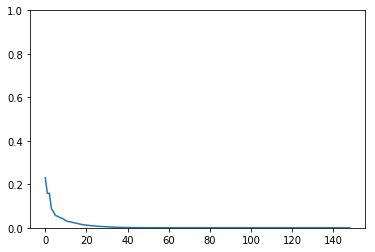

In [ ]:
trainFraction = 0.8
trainX,trainT,testX,testT = ml.partition(Xanuran,Tanuran,(trainFraction,1-trainFraction),classification=True)
trainX.shape,trainT.shape
nnet = nn.NeuralNetworkClassifier(trainX.shape[1], [30, 30], len(np.unique(Tanuran)))
nnet.train(trainX, trainT, 3000)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

This neural network converges very quickly. I wasn't sure how fast it would run, but when I left it, I had it train with 900 iterations. It really only needed about 60 it seems.

In [ ]:
netsAnuran = [0, 5, 20, 50, [24, 12, 6],
              [10, 5], [20, 20], [30, 30], [40, 10]]
results = trainNNs(Xanuran, Tanuran, 0.8, netsAnuran, 3, 900, True, verbose=True)

Measuring: 0
Training time: 17.370338678359985
Measuring: 5
Training time: 39.438969373703
Measuring: 20
Training time: 64.96660256385803
Measuring: 50
Training time: 142.21496629714966
Measuring: [24, 12, 6]
Training time: 108.92780613899231
Measuring: [10, 5]
Training time: 65.34082078933716
Measuring: [20, 20]
Training time: 28.792356252670288
Measuring: [30, 30]
Training time: 29.161375284194946
Measuring: [40, 10]
Training time: 44.05172157287598


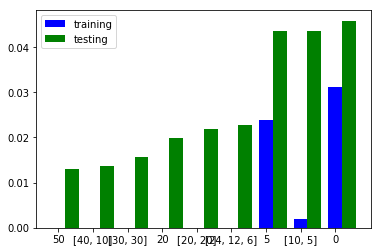

In [ ]:
plotSummary(summarize(results))

The model seems to be really good at memorizing the data, but not performing very well on the testing data. This is probably because I have way too many iterations.

In [ ]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average fraction missed Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

(50, 0.0, 0.012971971276349317, 142.21496629714966)
Hidden Layers 50 Average fraction missed Training 0.00 Testing 0.01 Took 142.21 seconds


Now do an investigation like you did for the regression data. 

Plot the predicted and actual `Species` for the testing data as an integer.  Discuss what you see.

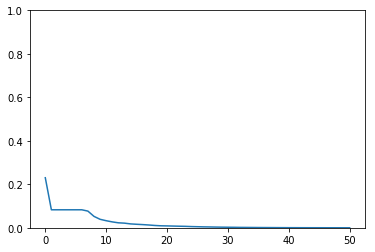

In [27]:
trainFraction = 0.8
trainX,trainT,testX,testT = ml.partition(Xanuran,Tanuran,(trainFraction,1-trainFraction),classification=True)
trainX.shape,trainT.shape
nnet = nn.NeuralNetworkClassifier(trainX.shape[1], 50, len(np.unique(Tanuran)))
nnet.train(trainX, trainT, 50)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

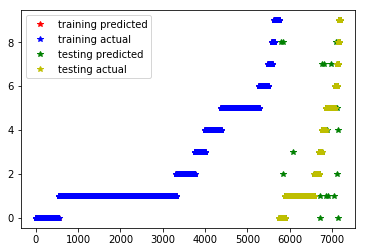

In [28]:
trainY = nnet.use(trainX)
testY = nnet.use(testX)
plt.plot(trainY, 'r*', label="training predicted")
plt.plot(trainT, 'b*', label="training actual")
plt.plot(range(len(trainY), len(trainY)+len(testY)), testY, 'g*', label="testing predicted")
plt.plot(range(len(trainT), len(trainT)+len(testT)), testT, 'y*', label="testing actual")
plt.legend()

It reflects that the training set is memorized, and that it loosely helps the model predict correctly what the actual labels are.

## Grading

Download [A5grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A5grader.tar) and extract `A5grader.py` from it.

In [6]:
%run -i "A5grader.py"


======================= Code Execution =======================

Extracting python code from notebook named 'Wilson-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

--- 10/10 points. Correctly returned [([1, 1], 1.3, 2.3000000000000003, 0.5), ([2, 2, 2], 4.3, 6.3999999999999995, 0.6)]

Testing bestNetwork([[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 1.3, 0.6]])

--- 10/10 points. Correctly returned [[2, 2, 2], 4.3, 1.3, 0.6]

X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

--- 20/20 points. Correct.

Testing bestNetwork(summarize(result))

--- 20/20 points. You correctly found that network [20, 20] is best.

a5 Execution Grade

## Extra Credit

  2. Repeat the above regression and classification experiments with a second regression data set and a second classification data set.
  
  2. Since you are collecting the performance of all repetitions for each network structure, you can calculate a confidence interval about the mean, to help judge significant differences. Do this for either the regression or the classification data and plot the mean test performance with confidence intervals for each network structure tested.  Discuss the statistical significance of the differences among the means.  One website I found to help with this is the site [Correct way to obtain confidence interval with scipy](https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy).

# Regression analysis

Data source:
* http://archive.ics.uci.edu/ml/datasets/Student+Performance
* http://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip

From the attributes, we see that we need to one hot encode all but the following:
1. age
1. failures
1. famrel
1. freetime
1. goout
1. Dalc
1. Walc
1. health
1. absences
1. G1
1. G2
1. G3

Attributes:
1. school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
1. sex - student's sex (binary: "F" - female or "M" - male)
1. age - student's age (numeric: from 15 to 22)
1. address - student's home address type (binary: "U" - urban or "R" - rural)
1. famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
1. Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
1. Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
1. Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
1. Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
1. Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
1. reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
1. guardian - student's guardian (nominal: "mother", "father" or "other")
1. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
1. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
1. failures - number of past class failures (numeric: n if 1<=n<3, else 4)
1. schoolsup - extra educational support (binary: yes or no)
1. famsup - family educational support (binary: yes or no)
1. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
1. activities - extra-curricular activities (binary: yes or no)
1. nursery - attended nursery school (binary: yes or no)
1. higher - wants to take higher education (binary: yes or no)
1. internet - Internet access at home (binary: yes or no)
1. romantic - with a romantic relationship (binary: yes or no)
1. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
1. freetime - free time after school (numeric: from 1 - very low to 5 - very high)
1. goout - going out with friends (numeric: from 1 - very low to 5 - very high)
1. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
1. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
1. health - current health status (numeric: from 1 - very bad to 5 - very good)
1. absences - number of school absences (numeric: from 0 to 93)

Output:
1. G1 - first period grade (numeric: from 0 to 20)
1. G2 - second period grade (numeric: from 0 to 20)
1. G3 - final grade (numeric: from 0 to 20, output target)

In [46]:
!wget -nc -q 'http://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'
![ -f student-mat.csv ] || unzip student.zip

Archive:  student.zip
  inflating: student-mat.csv         
  inflating: student-por.csv         
  inflating: student-merge.R         
  inflating: student.txt             


In [47]:
names = "school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3".split(';')
noohe =  ["age", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences", "G1", "G2", "G3"]

Now we have to do one-hot encoding. This post helped me:
https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

## OneHotEncoding

Here you can see school being onehot encoded. It is removed and replaced with an encoded form: GP and MS

In [48]:
example = pd.read_csv('student-mat.csv', delimiter=";")

In [49]:
name = 'school'
dummy = pd.get_dummies(example.get(name))
example = example.drop(name, axis=1)
example = example.join(dummy, rsuffix="ohed")
example

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,goout,Dalc,Walc,health,absences,G1,G2,G3,GP,MS
0,F,18,U,GT3,A,4,4,at_home,teacher,course,...,4,1,1,3,6,5,6,6,1,0
1,F,17,U,GT3,T,1,1,at_home,other,course,...,3,1,1,3,4,5,5,6,1,0
2,F,15,U,LE3,T,1,1,at_home,other,other,...,2,2,3,3,10,7,8,10,1,0
3,F,15,U,GT3,T,4,2,health,services,home,...,2,1,1,5,2,15,14,15,1,0
4,F,16,U,GT3,T,3,3,other,other,home,...,2,1,2,5,4,6,10,10,1,0
5,M,16,U,LE3,T,4,3,services,other,reputation,...,2,1,2,5,10,15,15,15,1,0
6,M,16,U,LE3,T,2,2,other,other,home,...,4,1,1,3,0,12,12,11,1,0
7,F,17,U,GT3,A,4,4,other,teacher,home,...,4,1,1,1,6,6,5,6,1,0
8,M,15,U,LE3,A,3,2,services,other,home,...,2,1,1,1,0,16,18,19,1,0
9,M,15,U,GT3,T,3,4,other,other,home,...,1,1,1,5,0,14,15,15,1,0


Now if we onehot encode them all:

In [50]:
df = pd.read_csv('student-mat.csv', delimiter=";")
# We don't care about progress grades; we only care about the main one
df = df.drop('G1', axis=1)
df = df.drop('G2', axis=1)

# OHE
for name in list(df.columns):
    if not name in noohe:
        dummy = pd.get_dummies(df.get(name))
        df = df.drop(name, axis=1)
        df = df.join(dummy, rsuffix="ohed")

# Here's an example data point
np.array(df)[0,:]

array([18,  0,  4,  3,  4,  1,  1,  3,  6,  6,  1,  0,  1,  0,  0,  1,  1,
        0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,
        0,  1,  0,  0,  0,  1,  1,  0,  1,  0,  1,  0,  0,  1,  0,  1,  1,
        0,  1,  0])

Here's the labels

In [51]:
df.columns

Index(['age', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G3', 'GP', 'MS', 'F', 'M', 'R', 'U', 'GT3',
       'LE3', 'A', 'T', '0', '1', '2', '3', '4', '0ohed', '1ohed', '2ohed',
       '3ohed', '4ohed', 'at_home', 'healthohed', 'other', 'services',
       'teacher', 'at_homeohed', 'healthohed', 'otherohed', 'servicesohed',
       'teacherohed', 'course', 'home', 'otherohed', 'reputation', 'father',
       'mother', 'otherohed', '1', '2', '3', '4', '1ohed', '2ohed', '3ohed',
       '4ohed', 'no', 'yes', 'noohed', 'yesohed', 'noohed', 'yesohed',
       'noohed', 'yesohed', 'noohed', 'yesohed', 'noohed', 'yesohed', 'noohed',
       'yesohed', 'noohed', 'yesohed'],
      dtype='object')

As you can see, they are now useless..

In [52]:
np.array(df).shape

(395, 71)

## Data reformatting

In [53]:
data = np.array(df, dtype=np.float)
G3col = list(df.columns).index('G3')
Xschool = np.delete(data, G3col, 1)
Tschool = data[:,G3col]
Tschool = Tschool.reshape(Tschool.shape[0], 1)
Xschool.shape, Tschool.shape

((395, 70), (395, 1))

## Iteration measurement

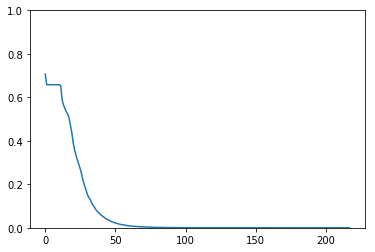

In [63]:
trainFraction = 0.8
trainX,trainT,testX,testT = ml.partition(Xschool,Tschool,(trainFraction,1-trainFraction),classification=False)
nnet = nn.NeuralNetwork(Xschool.shape[1], [60, 25], Tschool.shape[1])
nnet.train(trainX, trainT, 1500)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

The error levels off around 700 but continues to decrease slightly.

## Structure performance analysis

In [92]:
netsSchool = [0, 30, 70, 100, [80, 40, 20],
              [70, 20], 50, [25, 15], [30, 10]]
results = trainNNs(Xschool, Tschool, 0.8, netsSchool, 10, 100, classify=False, verbose=True)

Measuring: 0
Training time: 0.08411574363708496
Measuring: 30
Training time: 1.9142038822174072
Measuring: 70
Training time: 2.8603549003601074
Measuring: 100
Training time: 3.160750150680542
Measuring: [80, 40, 20]
Training time: 4.7348949909210205
Measuring: [70, 20]
Training time: 3.5105485916137695
Measuring: 50
Training time: 2.346574306488037
Measuring: [25, 15]
Training time: 1.9503579139709473
Measuring: [30, 10]
Training time: 2.559267997741699


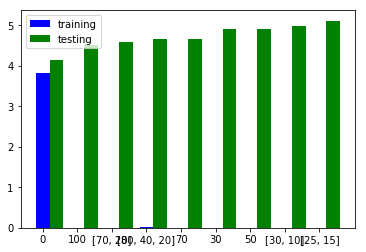

In [93]:
plotSummary(summarize(results))

Apparently, this data is very linear as it doesn't need any hidden nodes.

In [94]:
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*bestNetwork(summarize(results))))

Hidden Layers 0 Average RMSE Training 3.82 Testing 4.15 Took 0.08 seconds


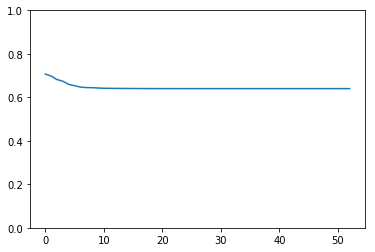

In [69]:
trainFraction = 0.8
trainX,trainT,testX,testT = ml.partition(Xenergy,Tenergy,(trainFraction,1-trainFraction),classification=False)
nnet = nn.NeuralNetwork(Xenergy.shape[1], 0, Tenergy.shape[1])
nnet.train(trainX, trainT, 75)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

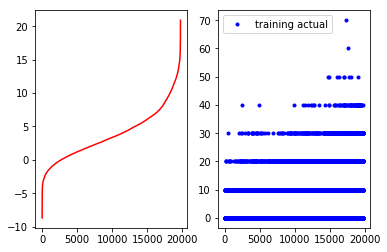

In [70]:
outY = list(nnet.use(trainX)[:,1]) +  list(nnet.use(testX)[:,1])
outT = list(trainT[:,1]) + list(testT[:,1])
zipped = sorted(list(zip(outY, outT)))
plt.subplot(121)
plt.plot([x[0] for x in zipped], 'r-', label="training predicted")
plt.subplot(122)
plt.plot([x[1] for x in zipped], 'b.', label="training actual")
plt.legend()

The error again correlates slightly it seems with the predicted data, but it always predicts things well beyond the score range, (since it's only 0-20), so this model doesn't do very well despite being the best.

# Classification Analysis

Data source:
* http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29
* http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data (the 05 feb 1996 dataset)

1. ID number
1. Diagnosis (M = malignant, B = benign)
1. (3 cells)
    1. radius (mean of distances from center to points on the perimeter)
    1. texture (standard deviation of gray-scale values)
    1. perimeter
    1. area
    1. smoothness (local variation in radius lengths)
    1. compactness (perimeter^2 / area - 1.0)
    1. concavity (severity of concave portions of the contour)
    1. concave points (number of concave portions of the contour)
    1. symmetry 
    1. fractal dimension ("coastline approximation" - 1)

In [72]:
!wget -nc -q 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

In [73]:
names = ['id', 'diagnosis']
cells = ['radius', 'texture', 'perimiter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimention']
for cell in [[cell+str(i) for cell in cells] for i in range(1, 4)]:
    names.extend(cell)
df = pd.read_csv('wdbc.data', header=None, names=names)
data = np.array(df)

In [74]:
df

,id,diagnosis,radius1,texture1,perimiter1,area1,smoothness1,compactness1,concavity1,concave points1,...,radius3,texture3,perimiter3,area3,smoothness3,compactness3,concavity3,concave points3,symmetry3,fractal dimention3
0,842302,M,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.300100,0.147100,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.71190,0.26540,0.4601,0.11890
1,842517,M,20.570,17.77,132.90,1326.0,0.08474,0.07864,0.086900,0.070170,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.24160,0.18600,0.2750,0.08902
2,84300903,M,19.690,21.25,130.00,1203.0,0.10960,0.15990,0.197400,0.127900,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.45040,0.24300,0.3613,0.08758
3,84348301,M,11.420,20.38,77.58,386.1,0.14250,0.28390,0.241400,0.105200,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.68690,0.25750,0.6638,0.17300
4,84358402,M,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.198000,0.104300,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.40000,0.16250,0.2364,0.07678
5,843786,M,12.450,15.70,82.57,477.1,0.12780,0.17000,0.157800,0.080890,...,15.470,23.75,103.40,741.6,0.17910,0.52490,0.53550,0.17410,0.3985,0.12440
6,844359,M,18.250,19.98,119.60,1040.0,0.09463,0.10900,0.112700,0.074000,...,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.37840,0.19320,0.3063,0.08368
7,84458202,M,13.710,20.83,90.20,577.9,0.11890,0.16450,0.093660,0.059850,...,17.060,28.14,110.60,897.0,0.16540,0.36820,0.26780,0.15560,0.3196,0.11510
8,844981,M,13.000,21.82,87.50,519.8,0.12730,0.19320,0.185900,0.093530,...,15.490,30.73,106.20,739.3,0.17030,0.54010,0.53900,0.20600,0.4378,0.10720
9,84501001,M,12.460,24.04,83.97,475.9,0.11860,0.23960,0.227300,0.085430,...,15.090,40.68,97.65,711.4,0.18530,1.05800,1.10500,0.22100,0.4366,0.20750


In [75]:
names = list(df.columns)
data = np.array(df)
Xcancer = np.array(data[:,2:], dtype=np.float)
Tcancer = np.array([0 if diagnosis == 'B' else 1 for diagnosis in data[:,1]], dtype=np.int)
Tcancer = Tcancer.reshape(Tcancer.shape[0], 1)
Xcancer.shape, Tcancer.shape

((569, 30), (569, 1))

In [76]:
for i in range(2):
    print('{} samples in class {}'.format(np.sum(Tcancer==i), i))

357 samples in class 0
212 samples in class 1


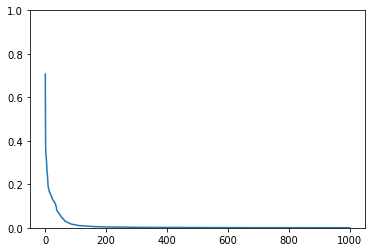

In [77]:
trainFraction = 0.8
trainX,trainT,testX,testT = ml.partition(Xcancer,Tcancer,(trainFraction,1-trainFraction),classification=False)
nnet = nn.NeuralNetwork(Xcancer.shape[1], [30, 30], Tcancer.shape[1])
nnet.train(trainX, trainT, 1000)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

In [89]:
netsCancer = [0, 3, 10, 30, 50, [30, 30], [30, 10], [10, 5], [5, 4, 3], [20, 20]]
results = trainNNs(Xcancer, Tcancer, 0.8, netsCancer, 10, 300, classify=True, verbose=True)

Measuring: 0
Training time: 0.9747138023376465
Measuring: 3
Training time: 1.3431503772735596
Measuring: 10
Training time: 1.0158114433288574
Measuring: 30
Training time: 5.951678276062012
Measuring: 50
Training time: 7.876925706863403
Measuring: [30, 30]
Training time: 2.337556838989258
Measuring: [30, 10]
Training time: 1.8349030017852783
Measuring: [10, 5]
Training time: 0.9498035907745361
Measuring: [5, 4, 3]
Training time: 1.3644983768463135
Measuring: [20, 20]
Training time: 1.717733383178711


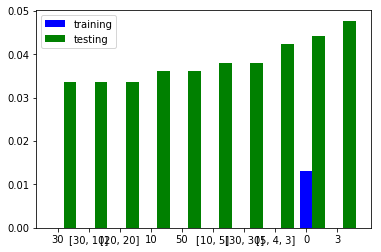

In [90]:
plotSummary(summarize(results))

It seems like I chose very linear datasets that aren't very complex. Even though the testing rate is high, the smaller networks seem to perform better than neural networks. That's good to keep in mind given the popularity of deep neural nets. They take forever to train and just memorize the answers of simple problem spaces.

In [91]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average fraction wrong Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

(30, 0.0, 0.033628318584070796, 5.951678276062012)
Hidden Layers 30 Average fraction wrong Training 0.00 Testing 0.03 Took 5.95 seconds


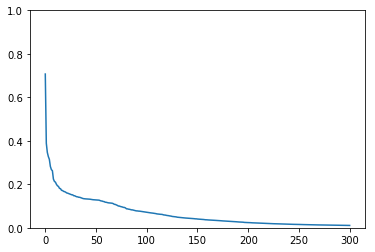

In [95]:
trainFraction = 0.8
trainX,trainT,testX,testT = ml.partition(Xcancer,Tcancer,(trainFraction,1-trainFraction),classification=False)
nnet = nn.NeuralNetwork(Xcancer.shape[1], 30, Tcancer.shape[1])
nnet.train(trainX, trainT, 300)
plt.ylim(0)
plt.plot(nnet.getErrorTrace())

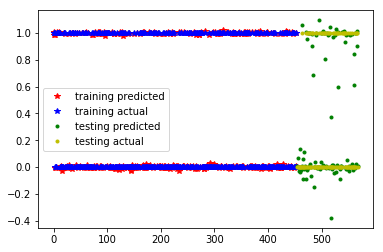

In [99]:
trainY = nnet.use(trainX)
testY = nnet.use(testX)
plt.plot(trainY, 'r*', label="training predicted")
plt.plot(trainT, 'b*', label="training actual")
plt.plot(range(len(trainY), len(trainY)+len(testY)), testY, 'g.', label="testing predicted")
plt.plot(range(len(trainT), len(trainT)+len(testT)), testT, 'y.', label="testing actual")
plt.legend()

It's really hard to read, and I should probably get better at `matplotlib`, but this is showing how accurate the model is. The testing error is very small, and it's only linear, which is interesting.

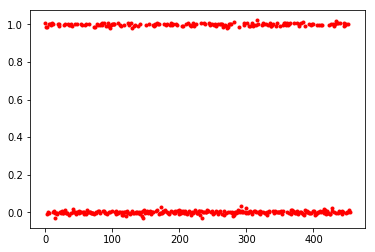

In [100]:
plt.plot(trainY, 'r.', label="training predicted")

I was curious if it was just classifying everything as just one type of something, but I suppose it wouldn't do that since it's accuracy wasn't high. When doing classification, that is something important to keep in mind: the classifier can just guess A for every answer and get an accuracy of about 20-25 percent.

In [102]:
results

[[0,
  [3.8171268004356844,
   3.8171268004356844,
   3.8171268004356844,
   3.8171268004356844,
   3.8171268004356844,
   3.8171268004356844,
   3.8171268004356844,
   3.8171268004356844,
   3.8171268004356844,
   3.8171268004356844],
  [4.147944020134522,
   4.147944020134522,
   4.147944020134522,
   4.147944020134522,
   4.147944020134522,
   4.147944020134522,
   4.147944020134522,
   4.147944020134522,
   4.147944020134522,
   4.147944020134522],
  0.08411574363708496],
 [30,
  [0.0005936993815895417,
   0.0045621552010814736,
   0.003760226602150291,
   0.0010447953699689516,
   0.0010589949001263074,
   0.0013238884804390445,
   0.0008560357647865752,
   0.0008221203392551703,
   0.0008481193149707943,
   0.00045152989628056126],
  [5.540270623506434,
   5.121861583965868,
   5.073528989921045,
   4.711993430073228,
   4.461875144284347,
   4.980677497403032,
   4.547722926114168,
   4.920197481482107,
   5.031231057222292,
   4.666200177322923],
  1.9142038822174072],
 [70,
  

## Confidence Intervals

In [117]:
testIntervals = [x[2] for x in results][1:] 
means = np.array([np.mean(x) for x in testIntervals])
stds = np.array([np.std(x) for x in testIntervals])
zscore = [1.645, 1.96, 2.576] # 90, 95, 99

Notice that I'm dropping the first data point, there is no variation and that messes things up. It's fair to say that since it doesn't have any variation that every point is within the confidence interval. Since there are no weights, it makes sense that there is no variation within the model, as it has no hidden units.

Further, notice that this is a set of samples from different distributions, so we don't use the confidence interval for means. We don't have to do any dividing the stds by the number of trials (since it's only 1).

Text(0.5,0,'[0, 30, 70, 100, [80, 40, 20], [70, 20], 50, [25, 15], [30, 10]]')

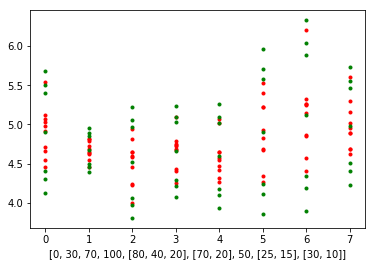

In [128]:
displacement = np.array([(
    mean-std*zscore[2],
    mean-std*zscore[1],
    mean-std*zscore[0],
    mean,
    mean+std*zscore[0],
    mean+std*zscore[1],
    mean+std*zscore[2]) for mean,std in zip(means,stds)])
plt.plot(testIntervals, 'r.')
plt.plot(displacement, 'g.')
plt.xlabel([result[0] for result in results])

Every point is within the 99 percent confidence interval, so there isn't any crazy variations. 0, [25,15] and [30,10] have points outside of the 95 percent confidence interval. 30 has very little variation, so would be a reliable model if consistency is important.